# PSI - Population Stability Index
Vinícius Trevisan 2022

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Data prep
from sklearn.model_selection import train_test_split

In [3]:
# Regression
from sklearn.linear_model import ElasticNet

In [4]:
def evaluate_regression(y, y_pred):
    
    '''
    Prints the most common evaluation metrics for regression
    '''
    
    mae = MAE(y, y_pred)
    mse = MSE(y, y_pred)
    rmse = mse ** (1/2)
    r2 = R2(y, y_pred)
    
    print('Regression result')
    print(f"MAE:  {mae:.4f}")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2:   {r2:.4f}")

In [5]:
def evaluate_classification(y, y_proba, threshold = 0.5):
    
    '''
    Prints the most common evaluation metrics for regression
    '''
    y_pred = [1 if y > threshold else 0 for y in y_proba]
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_proba)
    
    print('Classification result')
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1:        {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")

## Regressor

I will train a regressor with a synthetic dataset in a manner that:

$$y = a_1 \cdot x_1 + a_2 \cdot x_2 + a_3 \cdot x_3 + b$$

The features $x_1$, $x_2$ and $x_3$ will be sampled from different distributions and $y$ will be calculated for the train and test sets.

Then, I will create new features $z_1$, $z_2$ and $z_3$ which are the same features as before, but sampled with a slight deviation on $x_2$ to create $z_2$ and a large deviation on $x_3$ to create $z_3$. The feature $z_1$ will come from exactly the same distribution as $x_1$.

### Create Synthetic Dataset

In [6]:
# Sample size 
size = 5000

In [7]:
# Create random samples
x1 = np.random.normal(loc = 0, scale = 2, size = size)
x2 = np.random.normal(loc = 3, scale = 1, size = size)
x3 = np.random.normal(loc = 5, scale = 2, size = size)

Text(0.5, 1.0, 'Distribution of the features')

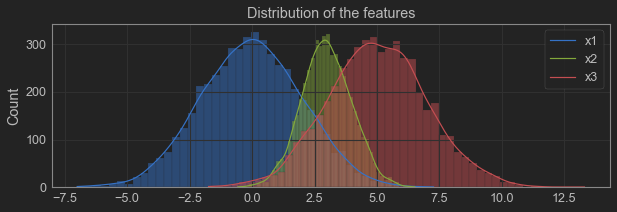

In [8]:
# Visualize them
plt.figure(figsize = (10,3))
sns.histplot(x1, kde = True, color = 'b')
sns.histplot(x2, kde = True, color = 'g')
sns.histplot(x3, kde = True, color = 'r')
plt.legend(["x1", "x2", "x3"])
plt.title("Distribution of the features")

In [9]:
# Create random samples
z1 = np.random.normal(loc = 0, scale = 2, size = size)  # The same as x1
z2 = np.random.normal(loc = 3.5, scale = 0.75, size = size)  # x2 with slight changes on scale and loc
z3 = np.random.normal(loc = 8, scale = 3, size = size)  # x3 with large changes on scale and loc

Text(0.5, 1.0, 'Distribution of the features')

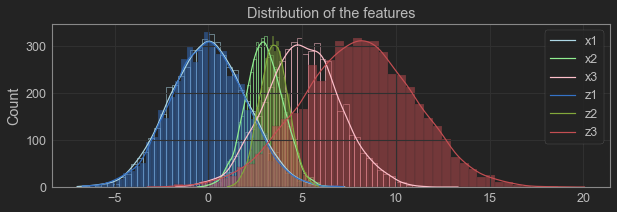

In [10]:
# Visualize them
plt.figure(figsize = (10,3))
sns.histplot(x1, kde = True, color = 'lightblue', fill = False)
sns.histplot(x2, kde = True, color = 'lightgreen', fill = False)
sns.histplot(x3, kde = True, color = 'pink', fill = False)
sns.histplot(z1, kde = True, color = 'b')
sns.histplot(z2, kde = True, color = 'g')
sns.histplot(z3, kde = True, color = 'r')
plt.legend(["x1", "x2", "x3", "z1", "z2", "z3"])
plt.title("Distribution of the features")

### Prepare train and test data

In [11]:
# yes, a2 = pi, a3 = e and b = phi
y = [-2*x1 + 3.1415*x2 + 2.7183*x3 + 1.6180 for (x1, x2, x3) in zip(x1,x2,x3)]

Text(0.5, 0.98, 'Regression curve for each feature')

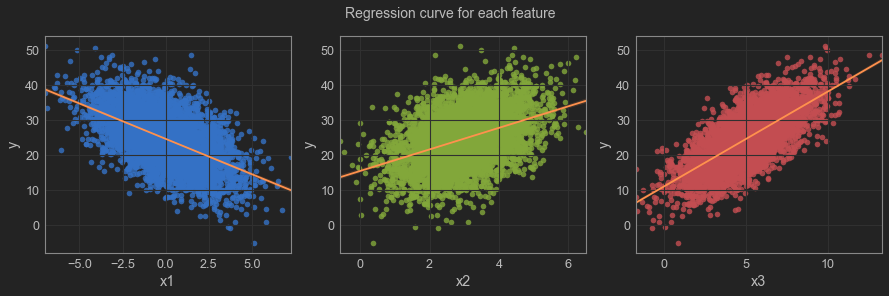

In [12]:
fig = plt.figure(figsize = (15,4))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)
sns.regplot(x = x1, y = y, ax = ax1, scatter_kws={"color": "b"}, line_kws={"color": "y"})
sns.regplot(x = x2, y = y, ax = ax2, scatter_kws={"color": "g"}, line_kws={"color": "y"})
sns.regplot(x = x3, y = y, ax = ax3, scatter_kws={"color": "r"}, line_kws={"color": "y"})
ax1.set_ylabel("y")
ax2.set_ylabel("y")
ax3.set_ylabel("y")
ax1.set_xlabel("x1")
ax2.set_xlabel("x2")
ax3.set_xlabel("x3")
fig.suptitle("Regression curve for each feature", fontsize = 14)

In [13]:
df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'y' : y})
X = df.drop(columns = 'y')
y = df['y']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### Train the regressor

In [15]:
model = ElasticNet()

In [16]:
model.fit(X_train, y_train)

ElasticNet()

In [17]:
y_pred = model.predict(X_test)

### Predict the shifted data

In [18]:
Z = pd.DataFrame({'x1': z1, 'x2': z2, 'x3': z3})

In [19]:
z_pred = model.predict(Z)

Text(0.5, 0.98, 'Regression curve for each feature')

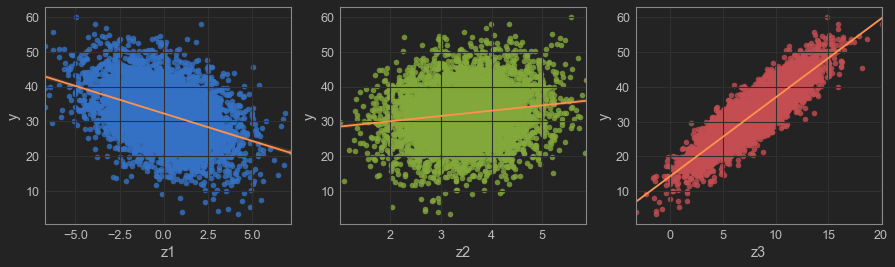

In [20]:
plt.figure(figsize = (15,4))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)
sns.regplot(x = z1, y = z_pred, ax = ax1, scatter_kws={"color": "b"}, line_kws={"color": "y"})
sns.regplot(x = z2, y = z_pred, ax = ax2, scatter_kws={"color": "g"}, line_kws={"color": "y"})
sns.regplot(x = z3, y = z_pred, ax = ax3, scatter_kws={"color": "r"}, line_kws={"color": "y"})
ax1.set_ylabel("y")
ax2.set_ylabel("y")
ax3.set_ylabel("y")
ax1.set_xlabel("z1")
ax2.set_xlabel("z2")
ax3.set_xlabel("z3")
fig.suptitle("Regression curve for each feature", fontsize = 14)

### Calculate the PSI - Fixed

In [21]:
score_initial = y_pred
score_new = z_pred
num_bins = 10
eps = 1e-4

In [22]:
# Sorts the data
score_initial.sort()
score_new.sort()

In [23]:
# Prepare the bins
min_val = min(min(score_initial), min(score_new))
max_val = max(max(score_initial), max(score_new))
bins = [min_val + (max_val - min_val)*(i)/num_bins for i in range(num_bins+1)]
bins[0] = min_val - eps # Corrects the lower boundary
bins[-1] = max_val + eps # Corrects the higher boundary

In [24]:
# Bucketize the initial population and count the sample inside each bucket
bins_initial = pd.cut(score_initial, bins = bins, labels = range(1,num_bins+1))
df_initial = pd.DataFrame({'initial': score_initial, 'bin': bins_initial})
grp_initial = df_initial.groupby('bin').count()
grp_initial['percent_initial'] = grp_initial['initial'] / sum(grp_initial['initial'])

In [25]:
grp_initial

,initial,percent_initial
bin,,
1,4,0.004
2,38,0.038
3,189,0.189
4,365,0.365
5,274,0.274
6,112,0.112
7,18,0.018
8,0,0.000
9,0,0.000


In [26]:
# Bucketize the new population and count the sample inside each bucket
bins_new = pd.cut(score_new, bins = bins, labels = range(1,num_bins+1))
df_new = pd.DataFrame({'new': score_new, 'bin': bins_new})
grp_new = df_new.groupby('bin').count()
grp_new['percent_new'] = grp_new['new'] / sum(grp_new['new'])

In [27]:
grp_new

,new,percent_new
bin,,
1,10,0.0020
2,55,0.0110
3,235,0.0470
4,729,0.1458
5,1301,0.2602
6,1376,0.2752
7,894,0.1788
8,311,0.0622
9,80,0.0160


In [28]:
# Compare the bins to calculate PSI
psi_df = grp_initial.join(grp_new, on = "bin", how = "inner")

In [29]:
psi_df

,initial,percent_initial,new,percent_new
bin,,,,
1,4,0.004,10,0.0020
2,38,0.038,55,0.0110
3,189,0.189,235,0.0470
4,365,0.365,729,0.1458
5,274,0.274,1301,0.2602
6,112,0.112,1376,0.2752
7,18,0.018,894,0.1788
8,0,0.000,311,0.0622
9,0,0.000,80,0.0160


In [30]:
# Add a small value for when the percent is zero
psi_df['percent_initial'] = psi_df['percent_initial'].apply(lambda x: eps if x == 0 else x)
psi_df['percent_new'] = psi_df['percent_new'].apply(lambda x: eps if x == 0 else x)

In [31]:
# Calculate the psi
psi_df['psi'] = (psi_df['percent_initial'] - psi_df['percent_new']) * np.log(psi_df['percent_initial'] / psi_df['percent_new'])

In [32]:
psi_df

,initial,percent_initial,new,percent_new,psi
bin,,,,,
1,4,0.0040,10,0.0020,0.001386
2,38,0.0380,55,0.0110,0.033472
3,189,0.1890,235,0.0470,0.197607
4,365,0.3650,729,0.1458,0.201151
5,274,0.2740,1301,0.2602,0.000713
6,112,0.1120,1376,0.2752,0.146717
7,18,0.0180,894,0.1788,0.369180
8,0,0.0001,311,0.0622,0.399486
9,0,0.0001,80,0.0160,0.080695


In [33]:
psi_plot = psi_df.reset_index()
psi_plot = pd.melt(psi_plot[['bin', 'percent_initial', 'percent_new']], id_vars = 'bin', var_name = 'set', value_name = 'percent')

Text(0.5, 1.0, 'Population distribution - Fixed size bins')

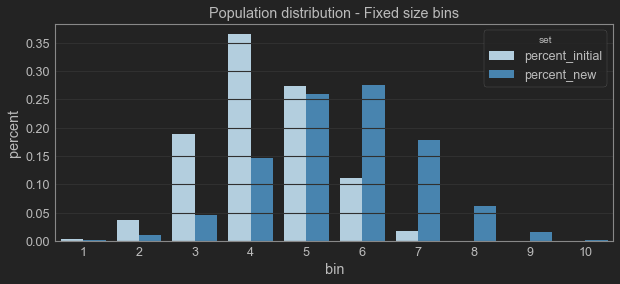

In [34]:
plt.figure(figsize = (10,4))
sns.barplot(x = 'bin', y = 'percent', hue = 'set', data = psi_plot, palette = 'Blues')
plt.title("Population distribution - Fixed size bins")

In [35]:
psi_values = psi_df['psi'].values

In [36]:
psi_values

array([0.00138629, 0.03347165, 0.19760712, 0.20115141, 0.00071315,
       0.14671668, 0.36918009, 0.39948558, 0.08069526, 0.00491363])

In [37]:
np.mean(psi_values)

0.14353208674966683

### Calculates the PSI - Quantiles

In [38]:
score_initial = y_pred
score_new = z_pred
num_bins = 10
eps = 1e-4

In [39]:
# Sort the data
score_initial.sort()
score_new.sort()

In [40]:
# Prepare the bins
min_val = min(min(score_initial), min(score_new))
max_val = max(max(score_initial), max(score_new))
bins = pd.qcut(score_initial, q = num_bins, retbins = True)[1]
bins[0] = min_val - eps # Corrects the lower boundary
bins[-1] = max_val + eps # Corrects the higher boundary

In [41]:
# Bucketize the initial population and count the sample inside each bucket
bins_initial = pd.cut(score_initial, bins = bins, labels = range(1,num_bins+1))
df_initial = pd.DataFrame({'initial': score_initial, 'bin': bins_initial})
grp_initial = df_initial.groupby('bin').count()
grp_initial['percent_initial'] = grp_initial['initial'] / sum(grp_initial['initial'])

In [42]:
grp_initial

,initial,percent_initial
bin,,
1,100,0.1
2,100,0.1
3,100,0.1
4,100,0.1
5,100,0.1
6,100,0.1
7,100,0.1
8,100,0.1
9,100,0.1


In [43]:
# Bucketize the new population and count the sample inside each bucket
bins_new = pd.cut(score_new, bins = bins, labels = range(1,num_bins+1))
df_new = pd.DataFrame({'new': score_new, 'bin': bins_new})
grp_new = df_new.groupby('bin').count()
grp_new['percent_new'] = grp_new['new'] / sum(grp_new['new'])

In [44]:
grp_new

,new,percent_new
bin,,
1,123,0.0246
2,138,0.0276
3,139,0.0278
4,165,0.0330
5,217,0.0434
6,260,0.0520
7,379,0.0758
8,380,0.0760
9,783,0.1566


In [45]:
# Compare the bins to calculate PSI
psi_df = grp_initial.join(grp_new, on = "bin", how = "inner")

In [46]:
psi_df

,initial,percent_initial,new,percent_new
bin,,,,
1,100,0.1,123,0.0246
2,100,0.1,138,0.0276
3,100,0.1,139,0.0278
4,100,0.1,165,0.0330
5,100,0.1,217,0.0434
6,100,0.1,260,0.0520
7,100,0.1,379,0.0758
8,100,0.1,380,0.0760
9,100,0.1,783,0.1566


In [47]:
# Add a small value for when the percent is zero
psi_df['percent_initial'] = psi_df['percent_initial'].apply(lambda x: eps if x == 0 else x)
psi_df['percent_new'] = psi_df['percent_new'].apply(lambda x: eps if x == 0 else x)

In [48]:
# Calculate the psi
psi_df['psi'] = (psi_df['percent_initial'] - psi_df['percent_new']) * np.log(psi_df['percent_initial'] / psi_df['percent_new'])

In [49]:
psi_df

,initial,percent_initial,new,percent_new,psi
bin,,,,,
1,100,0.1,123,0.0246,0.105743
2,100,0.1,138,0.0276,0.093204
3,100,0.1,139,0.0278,0.092426
4,100,0.1,165,0.0330,0.074280
5,100,0.1,217,0.0434,0.047245
6,100,0.1,260,0.0520,0.031388
7,100,0.1,379,0.0758,0.006705
8,100,0.1,380,0.0760,0.006586
9,100,0.1,783,0.1566,0.025386


In [50]:
psi_plot = psi_df.reset_index()
psi_plot = pd.melt(psi_plot[['bin', 'percent_initial', 'percent_new']], id_vars = 'bin', var_name = 'set', value_name = 'percent')

Text(0.5, 1.0, 'Population distribution - Quantile bins')

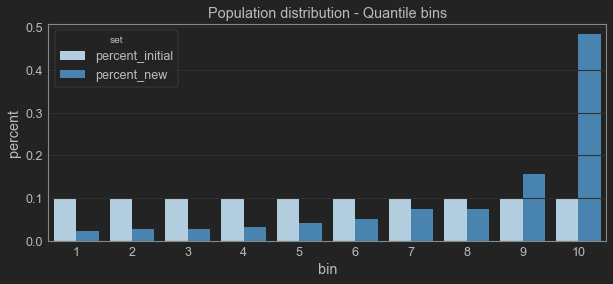

In [51]:
plt.figure(figsize = (10,4))
sns.barplot(x = 'bin', y = 'percent', hue = 'set', data = psi_plot, palette = 'Blues')
plt.title("Population distribution - Quantile bins")

In [52]:
psi_values = psi_df['psi'].values

In [53]:
psi_values

array([0.10574275, 0.09320446, 0.09242569, 0.0742804 , 0.04724463,
       0.03138847, 0.00670514, 0.00658648, 0.02538649, 0.60363981])

In [54]:
np.mean(psi_values)

0.10866043157715854